# IMPORTS

In [93]:
!pip install onnx tensorrt pycuda

In [94]:
!pip install cuda-python>=12.2.0

In [95]:
import numpy as np
import pandas as pd
import time
import os

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Onnx imports
import torch.onnx
import onnx

# TensorRT imports
import tensorrt as trt
from tensorrt import TensorIOMode # VERY USEFUL!

# Needed for inference
import pycuda.driver as cuda
import pycuda.autoinit

# Colab bug
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [96]:
DEVICE = 'cuda'

# Start with a Simple Network

In [97]:
class SimpleNN(nn.Module):
    def __init__(self):
        # super(SimpleNN, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN()
model.to(DEVICE)
model

SimpleNN(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

## Measure inference speed


In [98]:
num_iterations = 1000
total_time = 0.0
input_shape = (1, 10)

with torch.no_grad():
    for i in range(num_iterations):
        input_data = torch.randn(*input_shape).to(DEVICE)

        tik = time.time()
        output_data = model(input_data)
        tok = time.time()

        total_time += tok - tik

# Calculate frames per second (FPS)
pytorch_fps = num_iterations / total_time
print(f"PyTorch FPS: {pytorch_fps:.2f}")

PyTorch FPS: 3157.17


## Convert model to onnx
Requires dummy inputs

In [99]:
onnx_model_path = "/content/simple_nn.onnx"
dummy_input = torch.randn(1, 10).to(DEVICE)

torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    verbose=True
    )

print(f"Model exported to {onnx_model_path}")

Model exported to /content/simple_nn.onnx


In [100]:
# Check if the conversion happened well
model_onnx = onnx.load(onnx_model_path)
print(model_onnx.graph.input)

[name: "onnx::Gemm_0"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 10
      }
    }
  }
}
]




---



# Build the TensorRT engine from the ONNX model
Requires a bunch of features to be properly defined, like the logger, the builder etc. All new to me so nice! \
The code blocks below can be seen as **setting up all the variables and features** nicely.

In [101]:
# Set variables

# builder takes the logger as argument. Intersting!
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
builder = trt.Builder(TRT_LOGGER)

config = builder.create_builder_config()
cache = config.create_timing_cache(b"")
config.set_timing_cache(cache, ignore_mismatch=False)

# Explici batch flags are for handling dynamic shapes
flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

network = builder.create_network(flag)
parser = trt.OnnxParser(network, TRT_LOGGER)

In [102]:
# Load the onnx model
path_onnx_model = "/content/simple_nn.onnx"

# They say this is the way to parse the input.
# I find it intersting because this is only checking for errors while parsing :)
with open(path_onnx_model, "rb") as f:
    if not parser.parse(f.read()):
        print(f"ERROR: Failed to parse the ONNX file {path_onnx_model}")
        for error in range(parser.num_errors):
            print(parser.get_error(error))

In [103]:
inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]
print(f'inputs = {inputs}, outputs = {outputs}')

inputs = [<tensorrt_bindings.tensorrt.ITensor object at 0x79e1885e1070>], outputs = [<tensorrt_bindings.tensorrt.ITensor object at 0x79e188593530>]


In [104]:
# more settings
config.get_calibration_profile()
builder.platform_has_fast_fp16
trt.BuilderFlag.BF16

<ipython-input-104-7a17a39bcc35>:2: DeprecationWarning: Use Deprecated in TensorRT 10.1. Superseded by explicit quantization. instead.
  config.get_calibration_profile()


<BuilderFlag.BF16: 17>

In [105]:
# Reduce precision
half = True
int8 = False

if half:
    config.set_flag(trt.BuilderFlag.FP16)
elif int8:
    config.set_flag(trt.BuilderFlag.INT8)

In [106]:
# Load without unncessary weights if needed
strip_weights = True
if strip_weights:
    config.set_flag(trt.BuilderFlag.STRIP_PLAN)


In [107]:
# Build the TRT engine file
# Note how this is the serialize method
engine_bytes = builder.build_serialized_network(network, config)
engine_path = "/content/model.engine"

with open(engine_path, "wb") as f:
    f.write(engine_bytes)


## Load the Saved Engine and execute

In [108]:
# Execute engine
# Note how this is the DE-serialize method :)

# This can be loaded in two ways apparently
# The weight stripped engine and the usual engine

def load_stripped_engine_and_refit(
    engine_path: str,
    onnx_model_path: str,
) -> trt.ICudaEngine:

    runtime = trt.Runtime(TRT_LOGGER)
    with open(engine_path, "rb") as engine_file:
        engine = runtime.deserialize_cuda_engine(engine_file.read())
        refitter = trt.Refitter(engine, TRT_LOGGER)
        parser_refitter = trt.OnnxParserRefitter(refitter, TRT_LOGGER)

        assert parser_refitter.refit_from_file(onnx_model_path)
        assert refitter.refit_cuda_engine()
        return engine


def load_normal_engine(
    engine_path: str
) -> trt.ICudaEngine:

    # much simpler without many assertions
    runtime = trt.Runtime(TRT_LOGGER)
    with open(engine_path, "rb") as plan:
        engine = runtime.deserialize_cuda_engine(plan.read())
        return engine

In [109]:
if strip_weights:
    engine = load_stripped_engine_and_refit(engine_path, path_onnx_model)
else:
    engine = load_normal_engine(engine_path)

engine



---



## Inference with the TRT Engine

In [110]:
# Logger as earlier
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)

# Path to the 'serialized' TensorRT engine :)
engine_path = "/content/model.engine"

In [111]:
# Load the engine
def load_engine(engine_path: str) -> trt.ICudaEngine:

    # observe how this same as earlier
    runtime = trt.Runtime(TRT_LOGGER)

    with open(engine_path, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())
        return engine

engine = load_engine(engine_path)

In [112]:
# wrapping useful methods in a class trtEngineInference
# reference https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#perform_inference_python

class trtEngineInference:
    def __init__(self, engine_path: str):
        self.engine_path = engine_path
        self.TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)

        # setup the required things in init only
        self.engine = self.load_engine()
        self.context = self.engine.create_execution_context()
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers()

    def load_engine(self) -> trt.ICudaEngine:
        runtime = trt.Runtime(self.TRT_LOGGER)
        with open(self.engine_path, "rb") as f:
            return runtime.deserialize_cuda_engine(f.read())

    def allocate_buffers(self):
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()

        for binding in self.engine:
            binding_name = binding
            binding_shape = self.engine.get_tensor_shape(binding)
            binding_dtype = self.engine.get_tensor_dtype(binding)
            size = trt.volume(binding_shape) * 1 # self.engine.max_batch_size
            dtype = trt.nptype(binding_dtype)

            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)

            # Append the device buffer to device bindings
            bindings.append(int(device_mem))

            # Append to the appropriate list
            # The binding_is_input has been depreciated, but still shows on the documentation ExecutionContextpage, but not on the ICudaEngine page
            # Definitely confusing :/
            # https://developer.nvidia.com/docs/drive/drive-os/6.0.9/public/drive-os-tensorrt/api-reference/docs/python/infer/Core/ExecutionContext.html#tensorrt.IExecutionContext.get_binding_shape
            # https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/Engine.html

            # if engine.binding_is_input(binding):
            # The modes can be TensorIOMode.OUTPUT, TensorIOMode.INPUT, TensorIOMode.NONE,
            # https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/Engine.html

            if self.engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
                inputs.append({'name': binding_name, 'host': host_mem, 'device': device_mem})
            else:
                outputs.append({'name': binding_name, 'host': host_mem, 'device': device_mem})

        return inputs, outputs, bindings, stream

    def prepare_input_data(self, input_data: np.ndarray):
        # Copy input data to the host memory
        np.copyto(self.inputs[0]['host'], input_data.ravel())

        # Set tensor addresses for inputs and outputs
        for inp in self.inputs:
            self.context.set_tensor_address(inp['name'], int(inp['device']))
        for out in self.outputs:
            self.context.set_tensor_address(out['name'], int(out['device']))

    def do_inference(self):
        # Transfer data from CPU to GPU
        [cuda.memcpy_htod_async(inp['device'], inp['host'], self.stream) for inp in self.inputs]

        # Run inference
        self.context.execute_async_v3(stream_handle=self.stream.handle)

        # Transfer predictions back from the GPU.
        [cuda.memcpy_dtoh_async(out['host'], out['device'], self.stream) for out in self.outputs]

        # Synchronize the stream
        self.stream.synchronize()

        # Return only the host outputs.
        return [out['host'] for out in self.outputs]


In [113]:
# Inference for one input
engine_path = "/content/model.engine"
trt_engine = trtEngineInference(engine_path)

input_shape = (1, 10)  # Batch size of 1, 10 features
input_data = np.random.rand(*input_shape).astype(np.float32)
trt_engine.prepare_input_data(input_data)
output_data = trt_engine.do_inference()
output_data

[array([0.19997464], dtype=float32)]


## Measure inference speed

In [114]:
# Note how this little code block is similar to the one done previously for the pytorch model
num_iterations = 1000
total_time = 0.0
input_shape = (1, 10)

for i in range(num_iterations):
    input_data = np.random.rand(*input_shape).astype(np.float32)
    trt_engine.prepare_input_data(input_data)
    tik = time.time()
    output_data = trt_engine.do_inference()
    tok = time.time()
    total_time += tok - tik

tensorrt_fps = num_iterations / total_time
print(f"TensorRT FPS: {tensorrt_fps:.2f}")

TensorRT FPS: 30320.34


# Plot the speedup!

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: pagelocked_host_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: stream in out-of-thread context could not be cleaned up
  globals().clear()


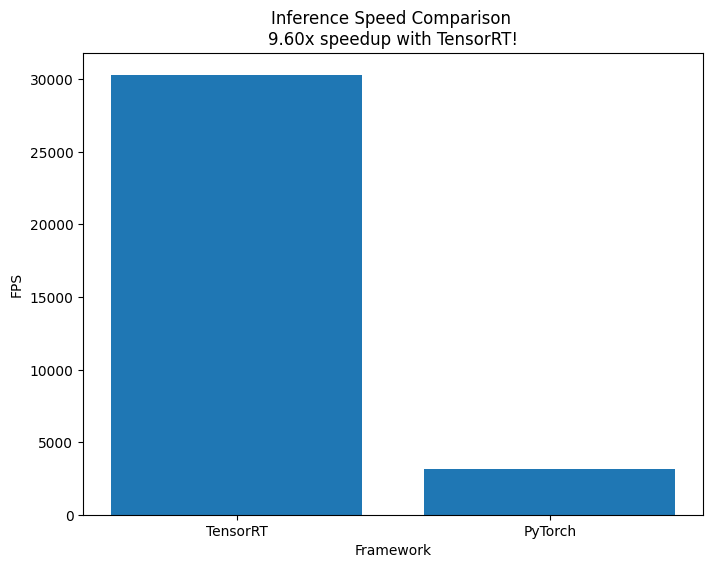

In [115]:
import matplotlib.pyplot as plt

values = [tensorrt_fps, pytorch_fps]
labels = ['TensorRT', 'PyTorch']

fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
ax.bar(labels, values)

ax.set_title(f'Inference Speed Comparison \n{tensorrt_fps/pytorch_fps :.2f}x speedup with TensorRT!')
ax.set_xlabel('Framework')
ax.set_ylabel('FPS')

plt.show()